# Topo MWTA Cifar Color

## Intro
* **Date**: 8/14/2022
* **What**: We're back baby!  It's been about one and a half years, but we're back.  I have some new ideas that I want to try regarding invariant classifiers.
* **Why**: My old classifiers were built around time-series invariants.  I want to see if I can learn invariants that are particularly useful in classifier settings.
* **Hopes**: I was a MWTA classifier that actually works, and it works by learning useful invariants.
* **Limitations**: New idea, so everything is going to fail.  Cheers!

## Code

In [77]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

m_len = 60_000
m_area = 28 * 28

(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr = x_tr / 255.0
x_te = x_te / 255.0

In [102]:
flat_tr = x_tr.reshape(-1, m_area)
flat_cr = np.zeros((m_len, 10))

for i in range(m_len):
    flat_cr[i, y_tr[i]] = 1

flat_te = x_te.reshape(-1, m_area)
flat_ce = np.zeros((len(x_te), 10))
for i in range(len(x_te)):
    flat_ce[i, y_te[i]] = 1

gp_ftr = cp.asarray(flat_tr)
gp_cr = cp.asarray(flat_cr)
gp_fte = cp.asarray(flat_te)
gp_ce = cp.asarray(flat_ce)

In [ ]:
def reconstruct(img_i, w, Kx, Ky, gp, vmax, vmin):
    s_len = 28

    img = gp[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.show()

In [192]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


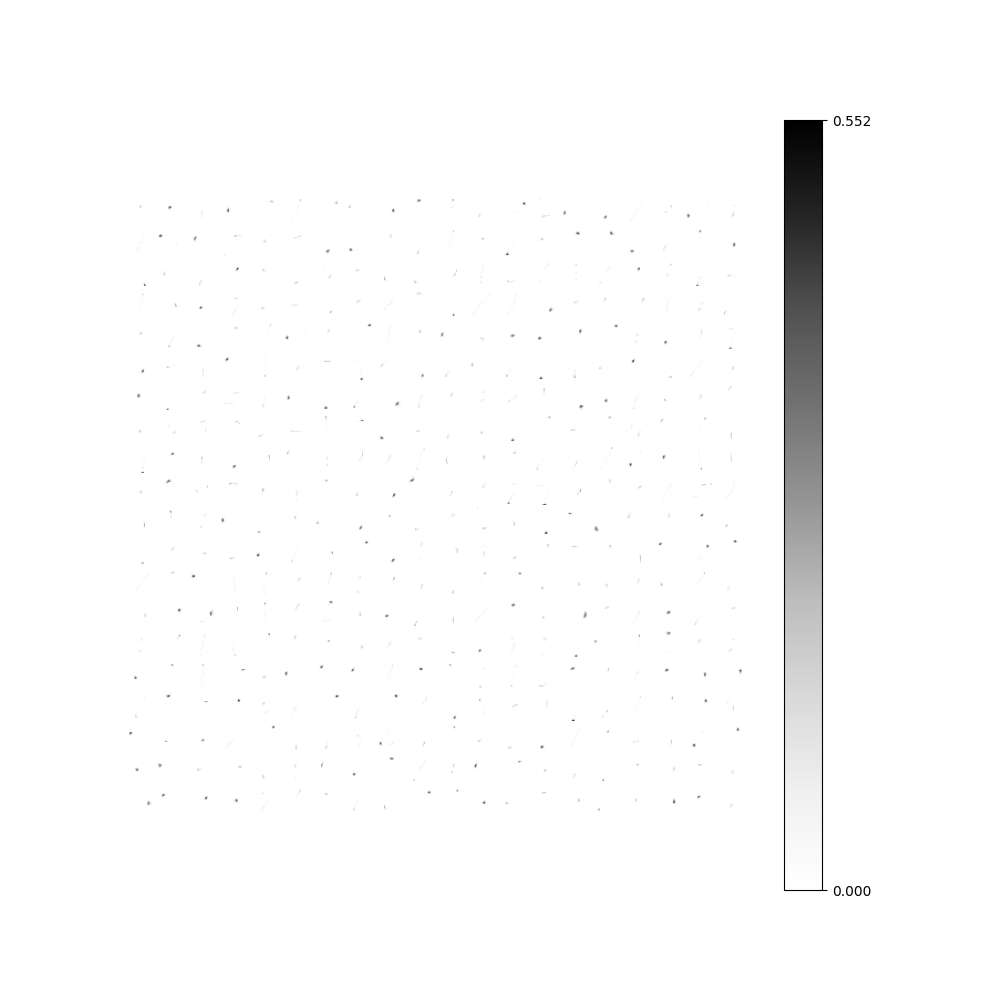

 12%|█▏        | 717/6000 [00:01<00:14, 369.30it/s]


KeyboardInterrupt: 

In [18]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 20
Ky = 20
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 30 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_ftr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


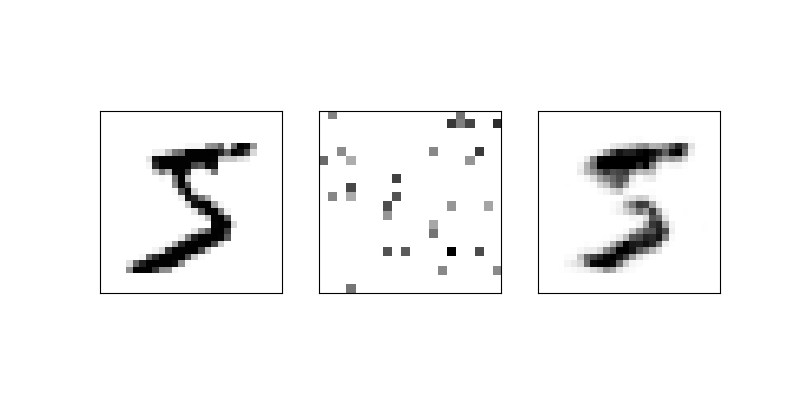

<IPython.core.display.Javascript object>


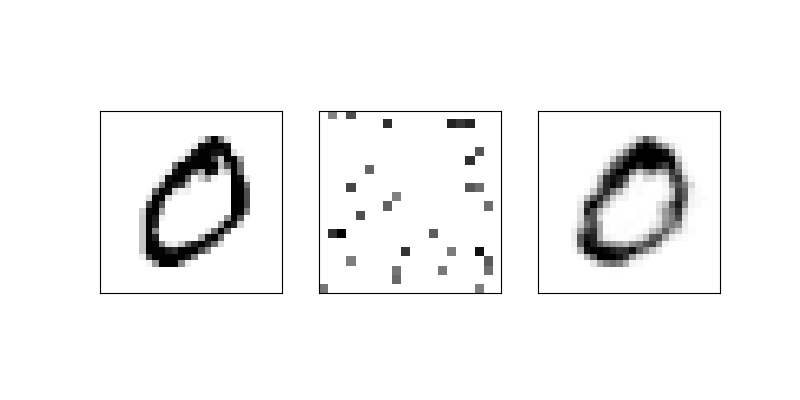

<IPython.core.display.Javascript object>


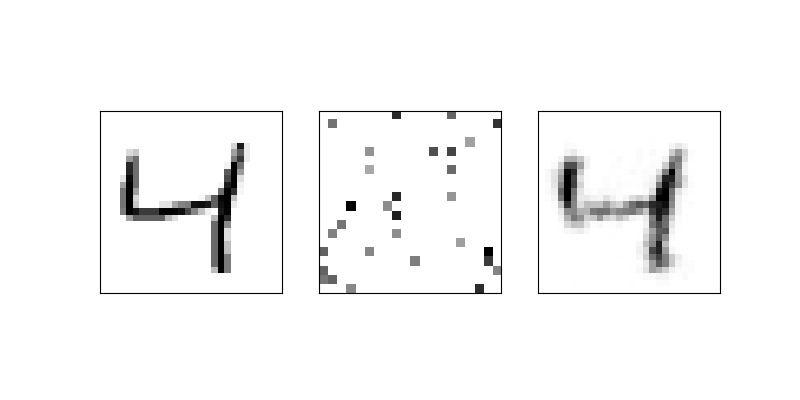

<IPython.core.display.Javascript object>


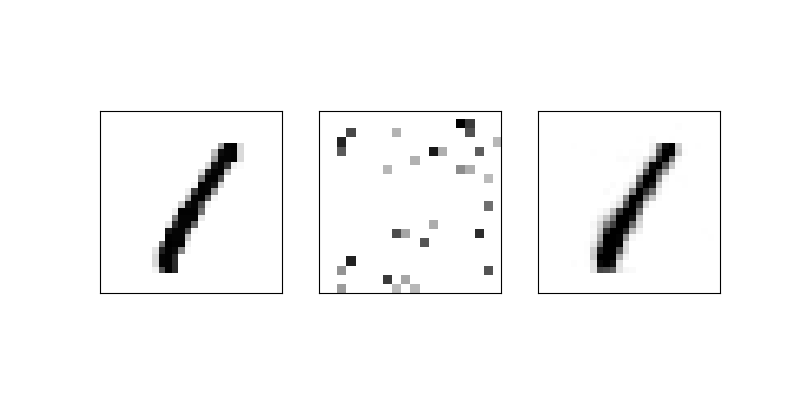

<IPython.core.display.Javascript object>


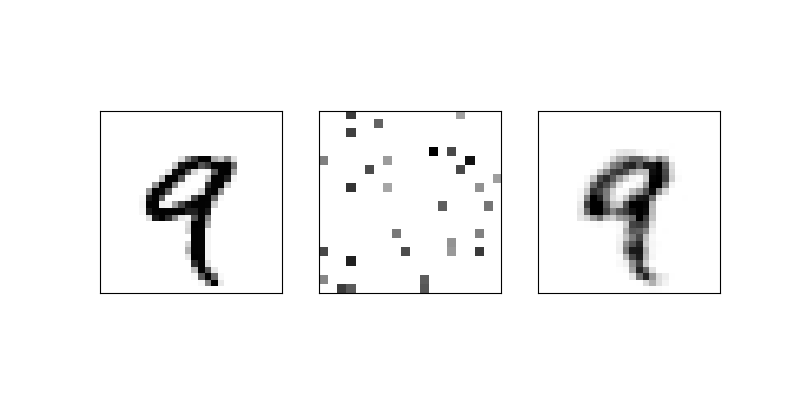

<IPython.core.display.Javascript object>


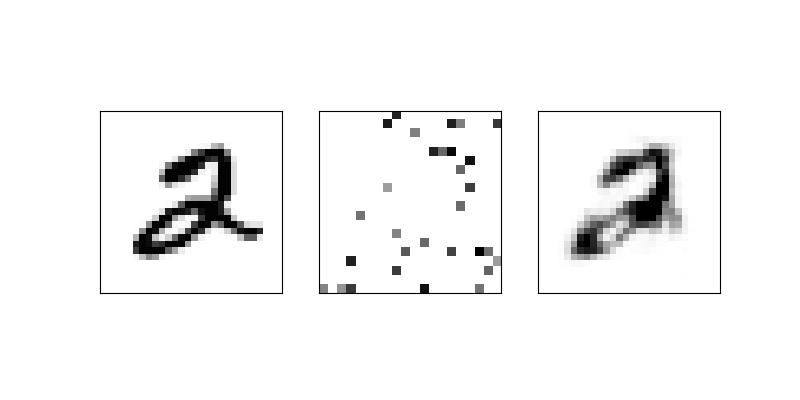

<IPython.core.display.Javascript object>


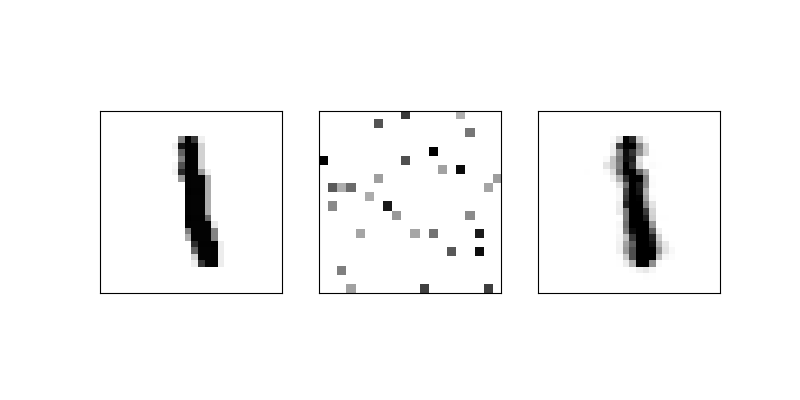

<IPython.core.display.Javascript object>


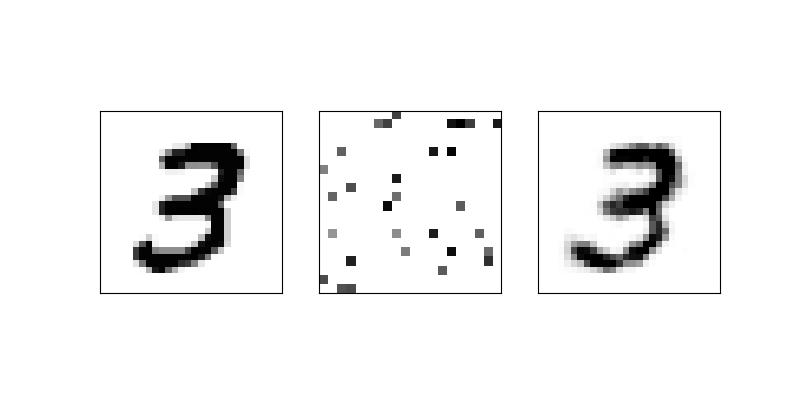

<IPython.core.display.Javascript object>


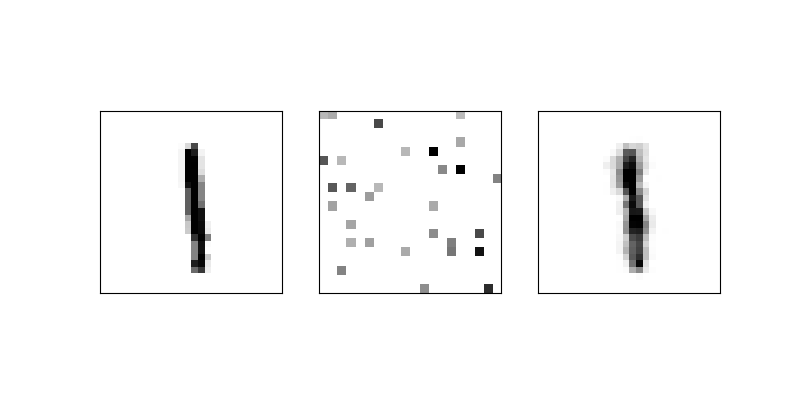

<IPython.core.display.Javascript object>


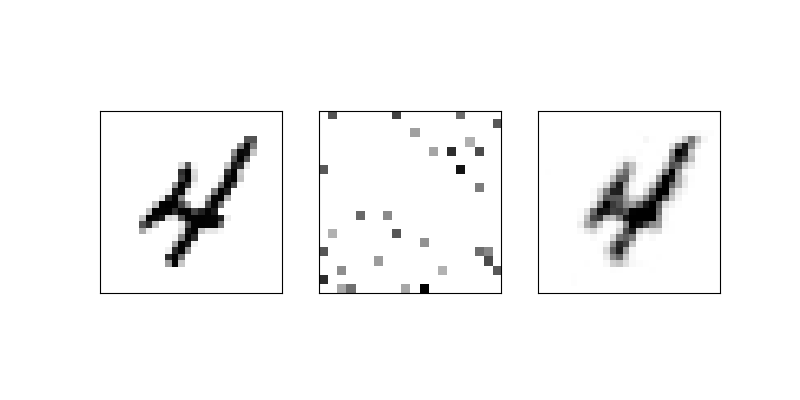

In [19]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_ftr, 1, 0)

Ok, I'm going to see I can successfully add lateral weights to this bitch, see what happens for higher numbers of weights.  Also, training is going to be really fucking slow when I have 5 layers of these things.  I might need to investigate other learning strategies there...

In [20]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

<IPython.core.display.Javascript object>


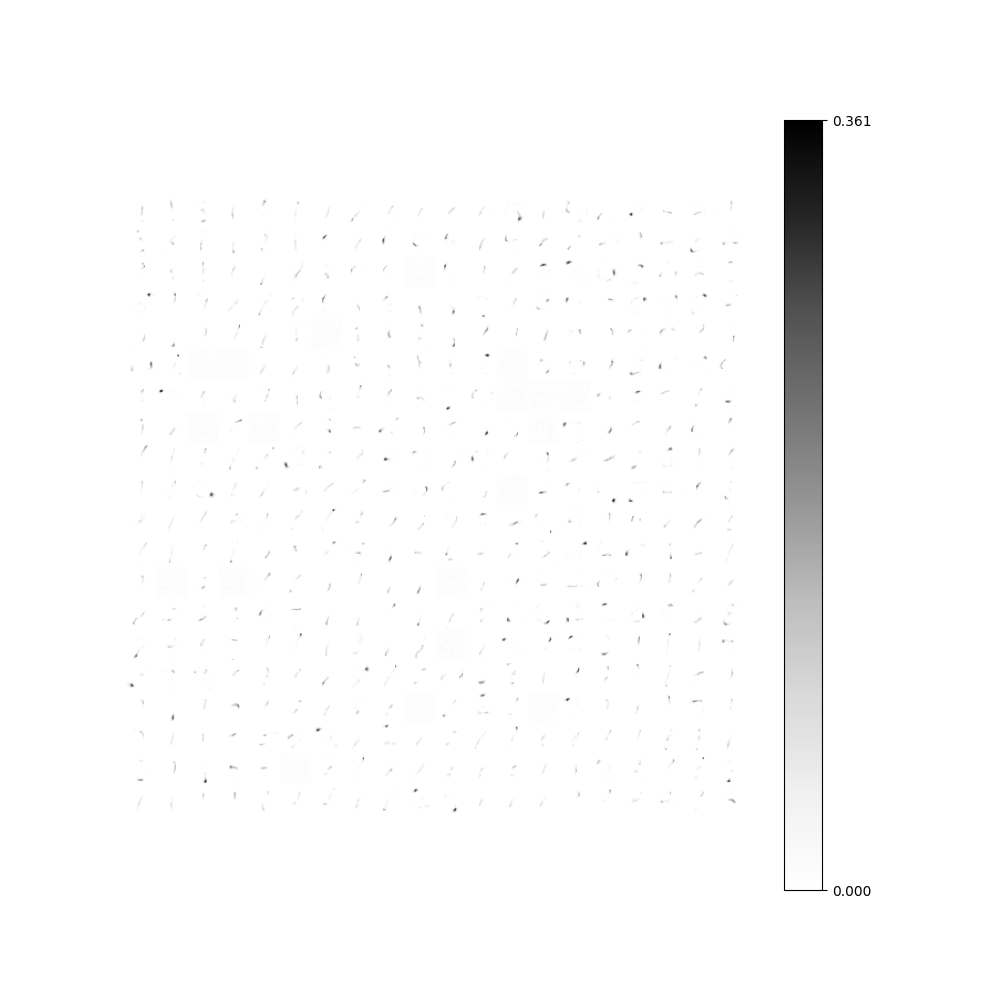

100%|██████████| 6000/6000 [00:14<00:00, 427.50it/s]


In [39]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 20
Ky = 20
m_len = 28 * 28 
tr_len = 60000

sex = 2
sex_coeff = 0.2

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

prec = 1e-10

n_w = 20 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_ftr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        c = w @ v
        p = s_lat_ex @ c # Lat ex
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


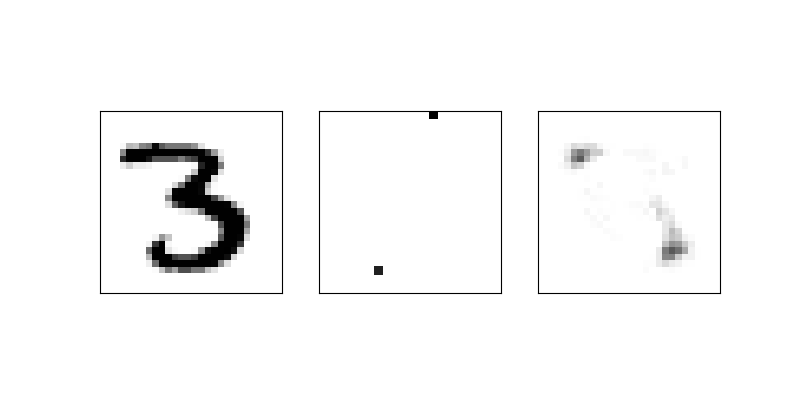

<IPython.core.display.Javascript object>


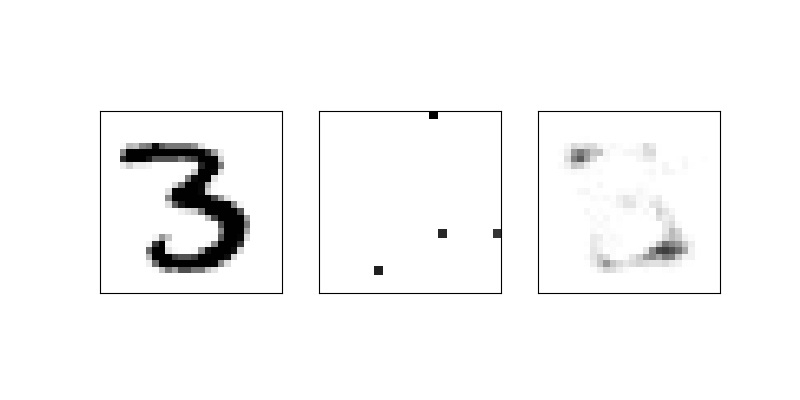

<IPython.core.display.Javascript object>


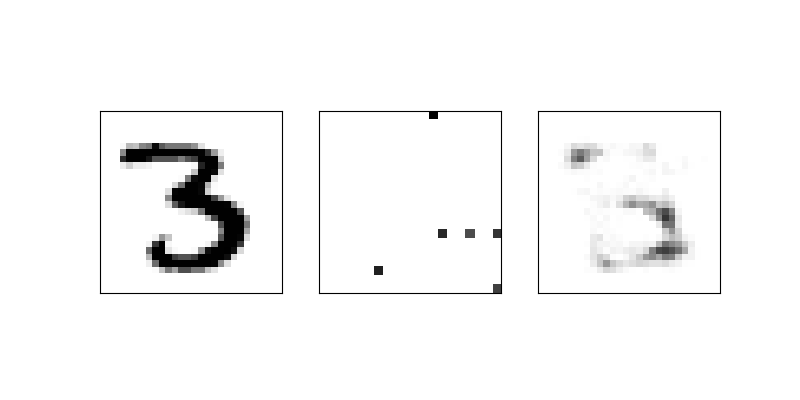

<IPython.core.display.Javascript object>


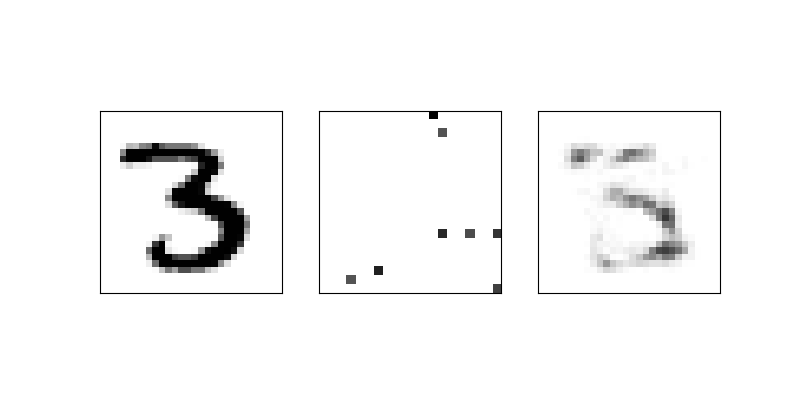

<IPython.core.display.Javascript object>


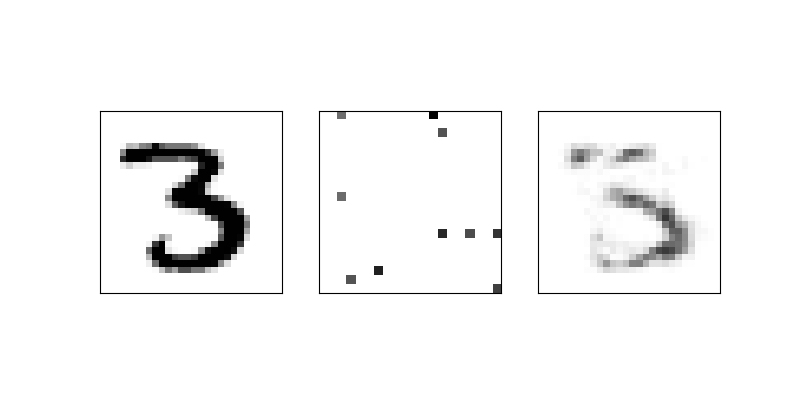

<IPython.core.display.Javascript object>


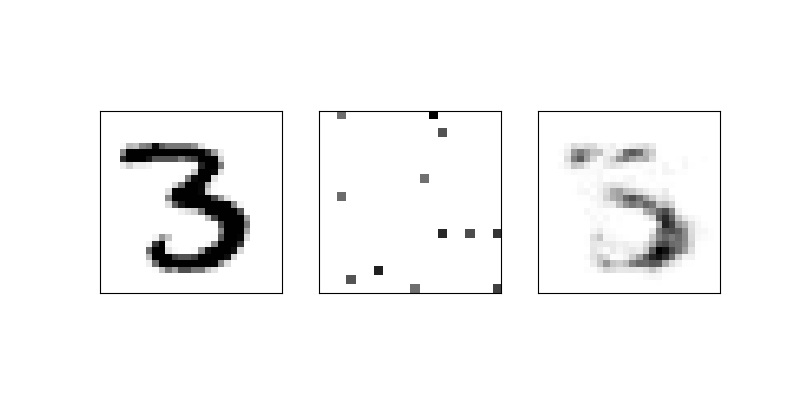

<IPython.core.display.Javascript object>


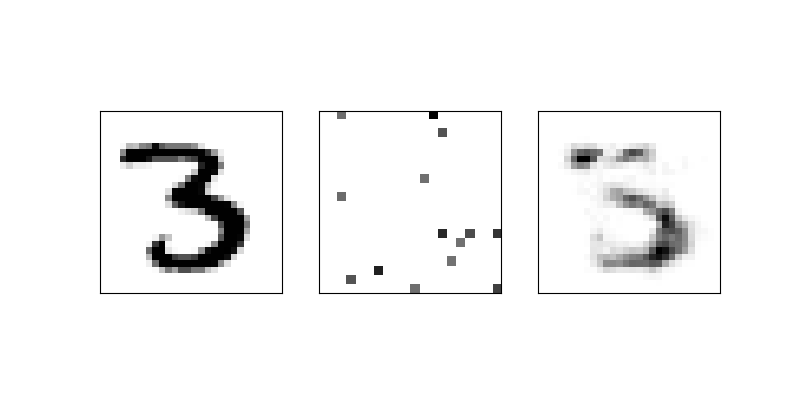

<IPython.core.display.Javascript object>


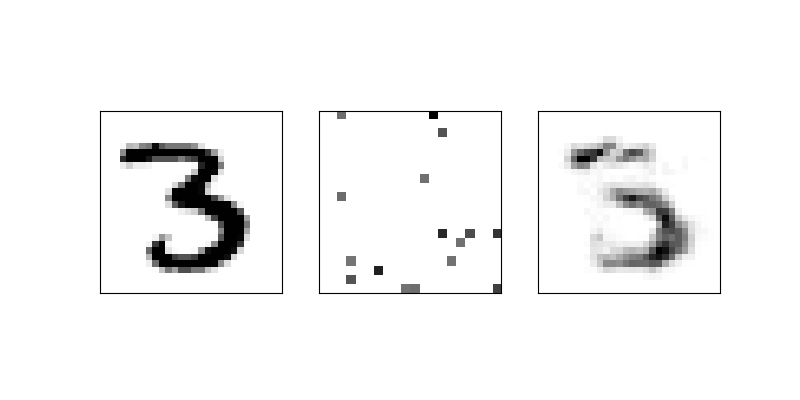

<IPython.core.display.Javascript object>


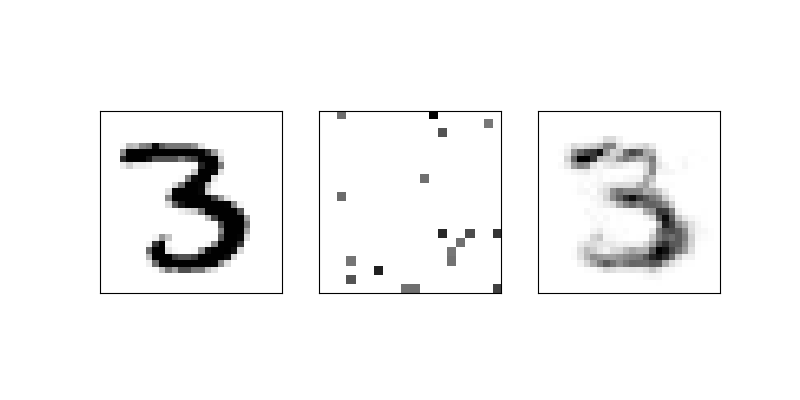

<IPython.core.display.Javascript object>


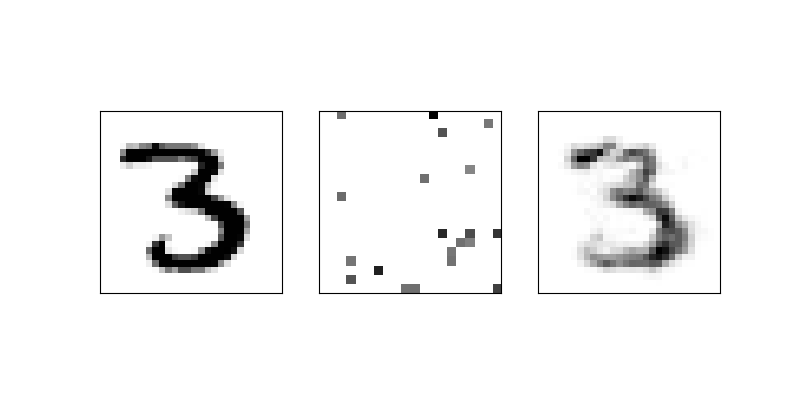

In [43]:
offset = 12
n_w = 2

for i in range(10):
    n_w = 2 * (i + 1)
    reconstruct(offset, w, Kx, Ky, gp_ftr, 1, 0)

Ok, interesting.  No time like the present to try all of this out.  And on lateral nonsense.  That might be useful to help guide invariant neurons, but we don't want that shit right now.  

<IPython.core.display.Javascript object>


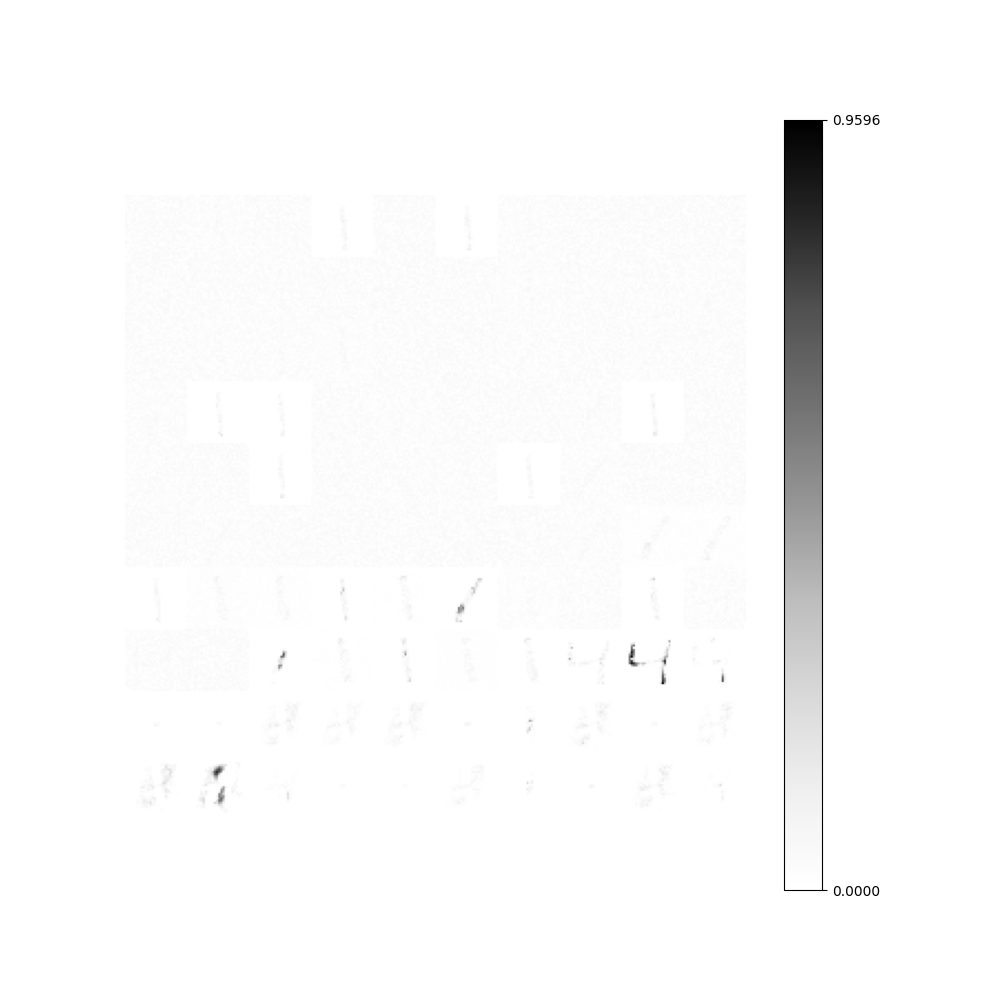

100%|██████████| 10/10 [00:00<00:00, 172.25it/s]


In [286]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 5
S2y = 5
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 20 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, iv_init * iv_b / iv_syn, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, iv_init * iv_t / iv_syn, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 100
T_s = 10
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
    rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1 = cp.zeros((NS1, 1))
        iv = cp.zeros((NIv, 1))
        s2 = cp.zeros((NS2, 1))
        
        for _ in range(passthrough_count): 
            s1 = hw1 * (w1 @ v) + (1 - hw1) * (w2 @ iv)
#             s1 = w1 @ v
            iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)
            s2 = hw3 * (w3 @ iv) + (1 - hw3) * (w4 @ cl)
            iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)
        
        s1 = cp.clip(s1, -1, 1)
        iv = cp.clip(iv, -1, 1)
        s2 = cp.clip(s2, -1, 1)
        
        if de2:
            print('s1', s1[:show_count])
            print('s2', s2[:show_count])
            print('iv', iv[:show_count])
            print('cl', cl[:show_count])
        
        s1_winners = cp.argsort(s1, axis=0)[-n_w1:]
        mask1 = cp.zeros((NS1, 1))
        mask1[s1_winners] = 1
        o1 = mask1 * s1
        
        iv_winners = cp.argsort(iv, axis=0)[-n_w1:]
        mask2 = cp.zeros((NIv, 1))
        mask2[iv_winners] = 1
        o2 = mask2 * iv
        
        s2_winners = cp.argsort(s2, axis=0)[-n_w1:]
        mask3 = cp.zeros((NS2, 1))
        mask3[s1_winners] = 1
        o3 = mask3 * s2
        
        r1 = w1.T @ o1
        mod_r1 = cp.maximum(r1, prec)
        e1 = cp.clip(v - r1, -1, 1)
        
        cc1 = w1 * o1 * (e1 / mod_r1).T * xi
        if debug: print('nan', cp.isnan(w1 + cc1).any())
        w1 += cc1
        
        if debug: print('max w1', cp.max(w1), cp.min(w1), cp.isnan(w1).any())
        
        r2 = w2.T @ o1
        mod_r2 = cp.maximum(r2, prec)
        e2 = cp.clip(o2 - r2, -1, 1)
        
        w2 += w2 * o1 * (e2 / mod_r2).T * xi
        
        if debug: print('max w2', cp.max(w2), cp.min(w2), cp.isnan(w2).any())
        
        r3 = w3.T @ o3
        mod_r3 = cp.maximum(r3, prec)
        e3 = cp.clip(o2 - r3, -1, 1)
        
        w3 += w3 * o3 * (e3 / mod_r3).T * xi
        if debug: print('max w3', cp.max(w3), cp.min(w3), cp.isnan(w3).any())

            
        r4 = w4.T @ o3
        mod_r4 = cp.maximum(r4, prec)
        e4 = cp.clip(cl - r4, -1, 1)
        
        w4 += w4 * o3 * (e4 / mod_r4).T * xi
        if debug: print('max w4', cp.max(w4), cp.min(w4), cp.isnan(w4).any())
        
        w1 = cp.clip(w1, 0, 1)
        w2 = cp.clip(w2, 0, 1)
        w3 = cp.clip(w3, 0, 1)
        w4 = cp.clip(w4, 0, 1)


        
    draw_weights(w1.get(), S1x, S1y, 28, fig)

In [283]:
w2[0]

array([1.23282383e-03, 4.49468242e-03, 2.04955542e-02, 5.54108608e-04,
       2.30652119e-03, 3.57951605e-03, 2.09341999e-02, 3.35713254e-03,
       3.52159532e-03, 2.16350456e-02, 8.86157425e-03, 1.85035464e-02,
       2.32023635e-03, 3.88901412e-03, 1.03422858e-03, 5.63865783e-03,
       5.24992194e-05, 3.95899431e-03, 2.44346986e-02, 2.72236820e-02,
       1.21192258e-02, 4.63740525e-04, 2.56139354e-03, 1.51281686e-03,
       2.44741550e-03, 7.04504054e-03, 8.36391950e-03, 2.15129708e-03,
       2.99083866e-03, 2.38312498e-02, 1.68462064e-03, 4.64738847e-03,
       2.49361966e-03, 1.46719352e-02, 1.46806007e-02, 4.56807356e-03,
       9.89755267e-03, 1.51179350e-04, 7.14698634e-03, 7.85208876e-03,
       9.90751013e-04, 1.02225447e-02, 4.25453236e-03, 2.02703932e-02,
       1.47707078e-03, 1.25538306e-03, 3.98997473e-03, 2.76928947e-03,
       6.77404118e-03, 6.40888979e-03])

In [264]:
g1[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [265]:
rand_pert = np.random.permutation(tr_len)
rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
inputs = gp_ftr[rand_pert]
outputs = gp_cr[rand_pert]
for i in tqdm(range(1)):
    v = inputs[i].reshape(-1, 1)
    cl = outputs[i].reshape(-1, 1)

    s1 = cp.zeros((NS1, 1))
    iv = cp.zeros((NIv, 1))
    s2 = cp.zeros((NS2, 1))

    for _ in range(passthrough_count): 
        s1 = hw1 * (w1 @ v) + (1 - hw1) * (w2 @ iv)
#             s1 = w1 @ v
        iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)
        s2 = hw3 * (w3 @ iv) + (1 - hw3) * (w4 @ cl)
        iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)

    if i > -1:
        print('s1', s1[:show_count])
        print('s2', s2[:show_count])
        print('iv', iv[:show_count])
        print('cl', cl[:show_count])



    s1_winners = cp.argsort(s1, axis=0)[-n_w1:]
    mask1 = cp.zeros((NS1, 1))
    mask1[s1_winners] = 1
    o1 = mask1 * s1

    iv_winners = cp.argsort(iv, axis=0)[-n_w1:]
    mask2 = cp.zeros((NIv, 1))
    mask2[iv_winners] = 1
    o2 = mask2 * iv

    s2_winners = cp.argsort(s2, axis=0)[-n_w1:]
    mask3 = cp.zeros((NS2, 1))
    mask3[s1_winners] = 1
    o3 = mask3 * s2

    r1 = w1.T @ o1
    mod_r1 = cp.maximum(r1, prec)
    e1 = cp.clip(v - r1, -1, 1)

    cc1 = w1 * o1 * (e1 / mod_r1).T * xi
    if debug: print('nan', cp.isnan(w1 + cc1).any())
    w1 += cc1

    if debug: print('max w1', cp.max(w1), cp.min(w1), cp.isnan(w1).any())

    r2 = w2.T @ o1
    mod_r2 = cp.maximum(r2, prec)
    e2 = cp.clip(o2 - r2, -1, 1)

    w2 += w2 * o1 * (e2 / mod_r2).T * xi

    if debug: print('max w2', cp.max(w2), cp.min(w2), cp.isnan(w2).any())

    r3 = w3.T @ o3
    mod_r3 = cp.maximum(r3, prec)
    e3 = cp.clip(o2 - r3, -1, 1)

    w3 += w3 * o3 * (e3 / mod_r3).T * xi
    if debug: print('max w3', cp.max(w3), cp.min(w3), cp.isnan(w3).any())


    r4 = w4.T @ o3
    mod_r4 = cp.maximum(r4, prec)
    e4 = cp.clip(cl - r4, -1, 1)

    w4 += w4 * o3 * (e4 / mod_r4).T * xi
    if debug: print('max w4', cp.max(w4), cp.min(w4), cp.isnan(w4).any())

    w1 = cp.clip(w1, 0, 1)
    w2 = cp.clip(w2, 0, 1)
    w3 = cp.clip(w3, 0, 1)
    w4 = cp.clip(w4, 0, 1)

100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

s1 [[1.40409801e+100]
 [7.73230780e+099]
 [6.36913028e+099]
 [3.27712352e+099]]
s2 [[1.01200070e+100]
 [2.17708174e+100]
 [2.48885905e+100]
 [3.99960040e+100]]
iv [[4.33750085e+101]
 [1.38546315e+099]
 [2.94641637e+101]
 [1.41119039e+099]]
cl [[0.]
 [0.]
 [0.]
 [0.]]


In [272]:
(cp.amax(w2, axis=1))

array([0.06805111, 0.03970295, 0.03076698, 0.01581926, 0.02047028,
       0.03494569, 0.02794388, 0.03338011, 0.01789119, 0.03590043,
       0.04005603, 0.03578245, 0.03725269, 0.02500659, 0.03704485,
       0.07486734, 0.02362841, 0.07285678, 0.05948399, 0.02077353,
       0.02280256, 0.02370845, 0.05134201, 0.01970489, 0.08102634,
       0.02148293, 0.02791903, 0.02056744, 0.02578906, 0.0322963 ,
       0.03664754, 0.0160326 , 0.116651  , 0.02483803, 0.03210885,
       0.01928577, 0.0223966 , 0.0218392 , 0.03054871, 0.04081996,
       0.25548662, 0.03302135, 0.03050639, 0.02756589, 0.0611758 ,
       0.02443637, 0.04068917, 0.02818392, 0.01975786, 0.08914582,
       0.02222037, 0.01778868, 0.02110847, 0.03327093, 0.03834535,
       0.06459733, 0.02653188, 0.02558208, 0.03855295, 0.01816754,
       0.03130624, 0.13009773, 0.02834618, 0.02006272, 0.09441525,
       0.03618714, 0.02526061, 0.02118141, 0.02143194, 0.02504533,
       0.12090902, 0.0238154 , 0.06474983, 0.01906266, 0.02329

In [269]:
w2.shape

(100, 50)